# INSTALLING ALL LIBRARIES

In [56]:
# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte

# modelling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import accuracy_score

# load/save file
import os
import pickle

## Pickle

In [4]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

In [5]:
SCALER_WG_FILE_PICKLE = "scaler_with_glcm.pkl"
SCALER_WOG_FILE_PICKLE = "scaler_without_glcm.pkl"
SVM_WG_FILE_PICKLE = "svm_with_glcm_model.pkl"
SVM_WOG_FILE_PICKLE = "svm_without_glcm_model.pkl"

## Testing GLCM

In [6]:
# TESTING GLCM
input_matrix = np.array([[0, 0, 1],
                          [1, 2, 3],
                          [2, 3, 2]])

glcm = graycomatrix(input_matrix, 
                    distances=[1], 
                    angles=[0], 
                    levels=4,
                    symmetric=True, 
                    normed=True)

print(glcm[:,:,0,0])

[[0.16666667 0.08333333 0.         0.        ]
 [0.08333333 0.         0.08333333 0.        ]
 [0.         0.08333333 0.         0.25      ]
 [0.         0.         0.25       0.        ]]


# Loading Image

In [7]:
# loading image function

def import_image(file) :
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resizing(image, 300)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [8]:
labels = ('freshapples','rottenapples')

raw_X_train = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_train = np.empty((0))

raw_X_test = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_test = np.empty((0))

# folder_path = "../dataset/train/" # for local used
# folder_path_train = "drive/MyDrive/Colab Notebooks/dataset/train/" # for drive used
# folder_path_test = "drive/MyDrive/Colab Notebooks/dataset/test/"

folder_path_train = "dataset/train/" # for drive used
folder_path_test = "dataset/test/"

for label in labels:
    # for train
    dataset_path_train = folder_path_train + label

    temp_X_train, temp_y_train = import_data(label, dataset_path_train)

    print("Size of train ", label, ":", temp_X_train.shape[0])
    
    raw_X_train = np.append(raw_X_train, temp_X_train, axis=0)
    raw_Y_train = np.append(raw_Y_train, temp_y_train, axis=0)

    # for test
    dataset_path_test = folder_path_test + label

    temp_X_test, temp_y_test = import_data(label, dataset_path_test)

    print("Size of test", label, ":", temp_X_test.shape[0])
    
    raw_X_test = np.append(raw_X_test, temp_X_test, axis=0)
    raw_Y_test = np.append(raw_Y_test, temp_y_test, axis=0)

print("Size of raw Test : ", raw_X_test.shape[0])
print("Size of raw Train : ", raw_X_train.shape[0])

Size of train  freshapples : 1693
Size of test freshapples : 395
Size of train  rottenapples : 2342
Size of test rottenapples : 601
Size of raw Test :  996
Size of raw Train :  4035


In [9]:
# 0 dimension -> showing all images
# 1st dimension -> spesific image
# 2nd dimension -> all pixel rgb color in 1 image
# 3rd dimension -> spesific pixel rgb
# 4th dimension -> spesific r/g/b
print(temp_X_test.shape)
print(raw_X_test[1][0][0])

(601, 300, 300, 3)
[0 0 0]


### Showing some images

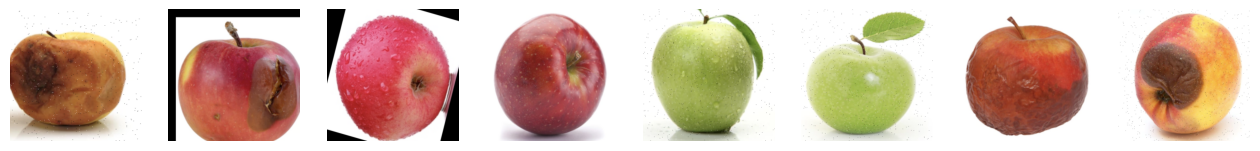

In [10]:
np.random.seed(42) #42 ascii nya bintang

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1

for i in range(1, columns*rows + 1):
    img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

### Showing Image RGB

Text(0.5, 0.98, 'Original & RGB image channels')

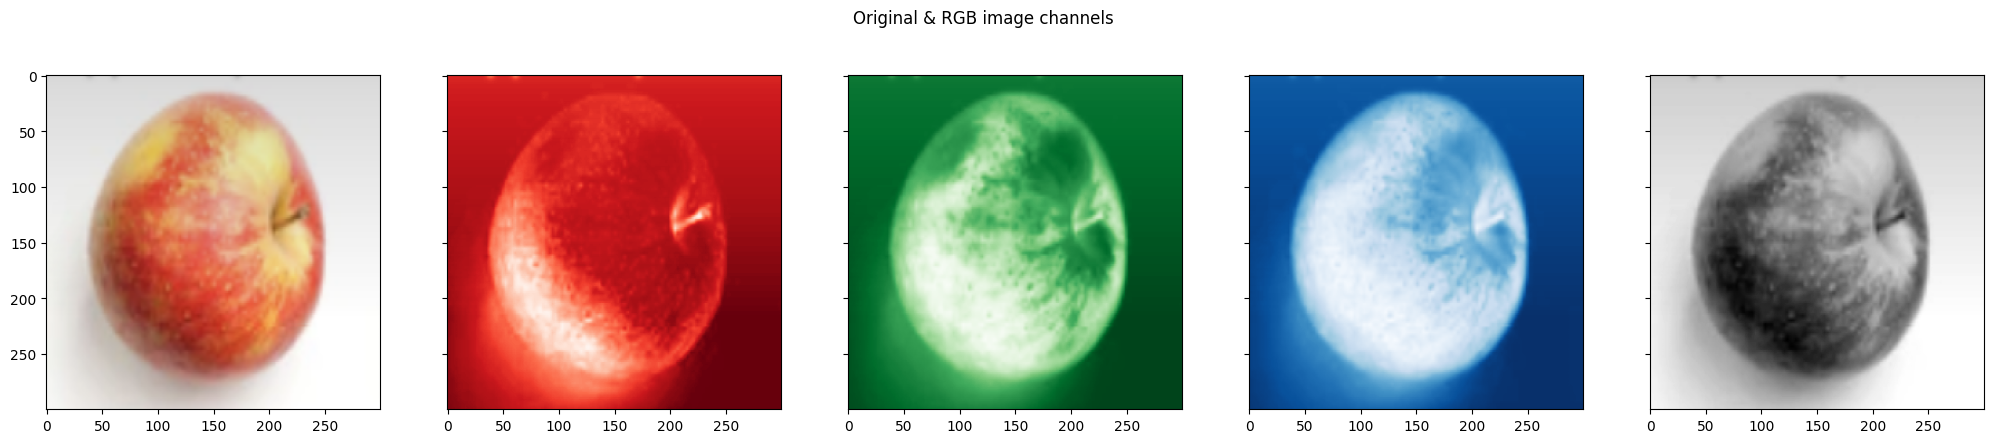

In [11]:
fig, (im1, im2, im3, im4, im5) = plt.subplots(1, 5, sharey=True)
fig.set_figwidth(25) 

img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

im1.imshow(img)  #Original image
im2.imshow(img[:, : , 0], cmap='Reds') #Red
im3.imshow(img[:, : , 1], cmap='Greens') #Green
im4.imshow(img[:, : , 2], cmap='Blues') #Blue
im5.imshow(img_gray, cmap='gray')
fig.suptitle('Original & RGB image channels')

### Showing Histogram

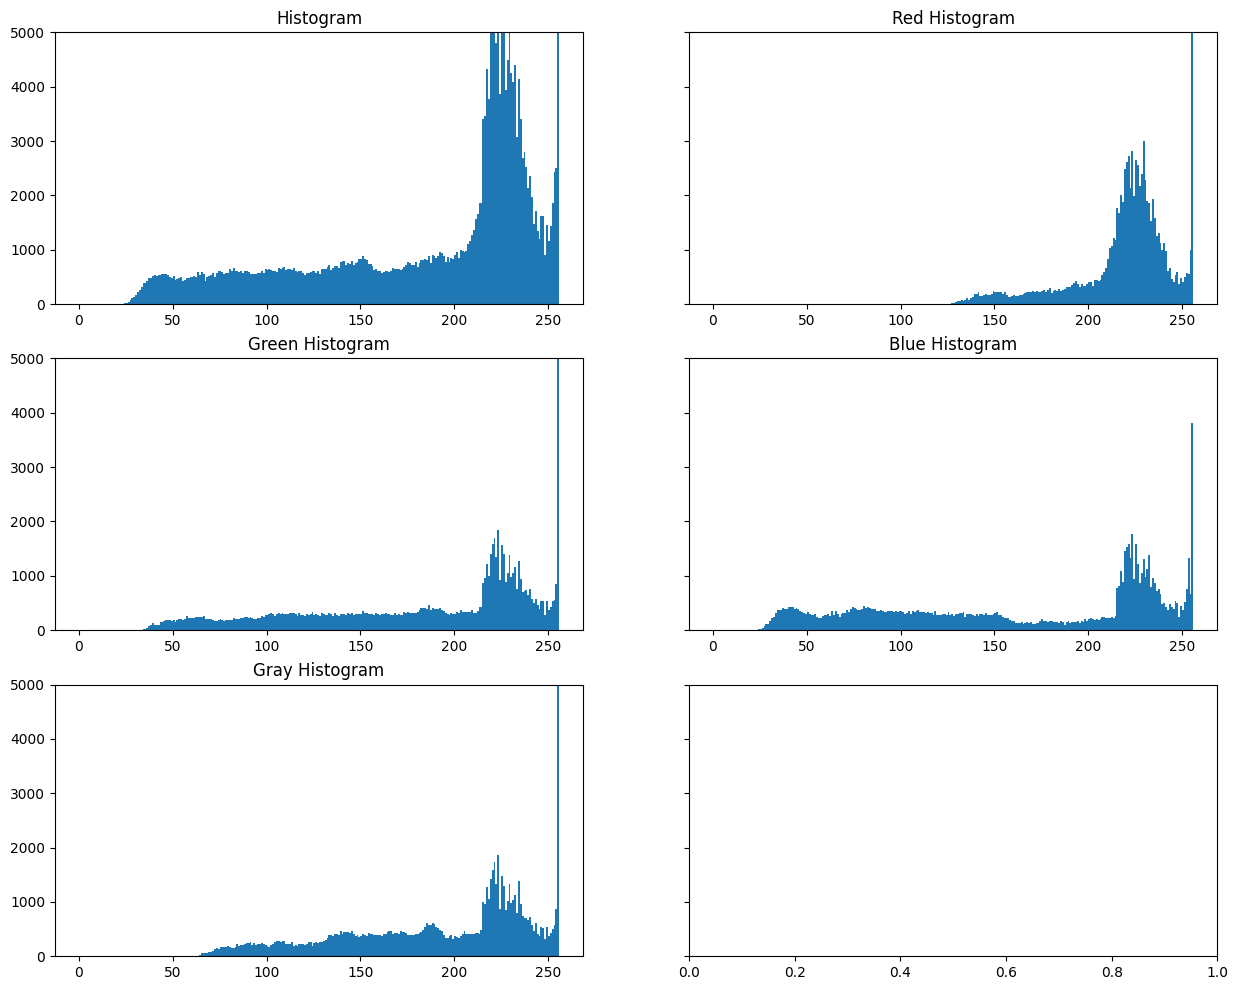

In [12]:
### Checking Histogram (normal color, RGB, grayscale) for knowing contrast and brightness
fig, ((im1, im2), (im3, im4), (im5, im6)) = plt.subplots(nrows=3, ncols=2, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(15)

# show the plotting graph of an image
im1.hist(img.ravel(),256,[0,256], label='RGB') # ravel is for flattening array from 2d to 1d array
im1.set_ylim(0,5000) # limit height of histogram
im1.set_title('Histogram')
im2.hist(img[:,:,0].ravel(),256,[0,256], label='R')
im2.set_title('Red Histogram')
im3.hist(img[:,:,1].ravel(),256,[0,256], label='G')
im3.set_title('Green Histogram')
im4.hist(img[:,:,2].ravel(),256,[0,256], label='B')
im4.set_title('Blue Histogram')
im5.hist(img_gray.ravel(),256,[0,256], label='Gray')
im5.set_title('Gray Histogram')
plt.show()

# Feature Extaction (GLCM)
preprocessing:
- resizing to 300x300
- grayscaling

augmentation(from dataset):
- rotate 15, 45, 60, 75
- salt and pepper
- translation
- vertical flip

In [13]:
# glcm properties
def contrast_feature(matrix_coocurrence):
	contrast = graycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = graycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = graycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = graycoprops(matrix_coocurrence, 'ASM')
	return asm

def gray_convertion(rgb_img):
	return cv2.cvtColor(rgb_img,cv2.COLOR_RGB2GRAY)

def glcm_extraction(img):
	glcm_feature = np.empty((0, 16), np.uint8)

	for i in range(img.shape[0]):
		img_gray = gray_convertion(img[i])
		
		# image = img_gray # 69.54% (16-bit)
		image = img_as_ubyte(img_gray) # 69.54% (16-bit), img as ubyte to convert image with value 0-255

		# bins = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255]) #8-bit = 66.9%
		bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit = 69.54%
		# bins = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit = 69.54%
		inds = np.digitize(image, bins) # buat nyari masing2 nilai dari image ada di index berapa kalau di array bins (pake indo biar ga ribet wkwk)

		max_value = inds.max()+1 # max value = 256
		matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)
		
		img_energy = energy_feature(matrix_coocurrence)
		img_correlation = correlation_feature(matrix_coocurrence)
		img_contrast = contrast_feature(matrix_coocurrence)
		img_homogenity = homogeneity_feature(matrix_coocurrence)
		# without dissimilarity (16-bit) = 69.54%
		# with dissimilarity (16-bit) = 68.94%
		# img_dissimilarity = dissimilarity_feature(matrix_coocurrence)
		# img_asm = asm_feature(matrix_coocurrence)

		temp_glcm_feature = np.empty(0)

		temp_glcm_feature = np.append(img_energy, img_correlation)
		temp_glcm_feature = np.append(temp_glcm_feature, img_contrast)
		temp_glcm_feature = np.append(temp_glcm_feature, img_homogenity)
		# temp_glcm_feature = np.append(temp_glcm_feature, img_dissimilarity)
		# temp_glcm_feature = np.append(temp_glcm_feature, img_asm)

		glcm_feature = np.append(glcm_feature, [temp_glcm_feature], axis=0)
	
	return glcm_feature
	

### Feature Testing

In [14]:
# source : https://github.com/renbooo/Gray-Level-Cooccurrence-Matrix/blob/master/glcm_fix.py
image = img_as_ubyte(img_gray)

bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
inds = np.digitize(image, bins)

max_value = inds.max()+1
matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

print(energy_feature(matrix_coocurrence))
print(correlation_feature(matrix_coocurrence))
print(contrast_feature(matrix_coocurrence))
print(homogeneity_feature(matrix_coocurrence))
print(dissimilarity_feature(matrix_coocurrence))
print(asm_feature(matrix_coocurrence))

[[0.29945806 0.29090222 0.30276149 0.29311088]]
[[0.99515185 0.99300153 0.99590207 0.99362097]]
[[0.09657748 0.13962931 0.08177258 0.12726927]]
[[0.95280825 0.93379604 0.95951505 0.9378687 ]]
[[0.09474916 0.13361148 0.08110368 0.12476371]]
[[0.08967513 0.0846241  0.09166452 0.08591399]]


### Feature Extraction

In [15]:
# glcm_feature = np.empty((0, 16), np.uint8)

glcm_feature = glcm_extraction(raw_X_train)

print(glcm_feature)
glcm_feature.shape
inds.max()+1   

[[0.3689621  0.36280636 0.37019465 ... 0.89058227 0.91525233 0.8891984 ]
 [0.35446676 0.34900676 0.35691431 ... 0.93066644 0.95162644 0.93770576]
 [0.29377118 0.28531848 0.29404457 ... 0.89387275 0.91849976 0.89240691]
 ...
 [0.32799973 0.31840303 0.33044106 ... 0.8707836  0.90936986 0.87048686]
 [0.36991467 0.36437832 0.37237129 ... 0.94171031 0.96217536 0.94259276]
 [0.44013292 0.43389755 0.44363952 ... 0.90466669 0.93584143 0.90572738]]


18

# Modelling (SVM+GLCM)

In [16]:
# Just load model without re-training if you want
svm_wg = load_file_pickle(SVM_WG_FILE_PICKLE)

In [17]:
# create parameter tuning
num_feature = glcm_feature.shape[1]
_var = glcm_feature.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)

0.6841
0.06841
[0.54728, 0.61569, 0.6841, 0.75251, 0.82092]


In [18]:
svm_wg_params = {
    'C': _c,
    'gamma': _gamma
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wg = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wg_params, cv=5, verbose=3)

In [19]:
svm_wg.fit(glcm_feature,raw_Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=1, gamma=0.54728;, score=0.701 total time=   2.6s
[CV 2/5] END ................C=1, gamma=0.54728;, score=0.690 total time=   2.6s
[CV 3/5] END ................C=1, gamma=0.54728;, score=0.665 total time=   2.6s
[CV 4/5] END ................C=1, gamma=0.54728;, score=0.601 total time=   2.5s
[CV 5/5] END ................C=1, gamma=0.54728;, score=0.621 total time=   2.6s
[CV 1/5] END ................C=1, gamma=0.61569;, score=0.700 total time=   2.6s
[CV 2/5] END ................C=1, gamma=0.61569;, score=0.689 total time=   2.6s
[CV 3/5] END ................C=1, gamma=0.61569;, score=0.672 total time=   2.6s
[CV 4/5] END ................C=1, gamma=0.61569;, score=0.606 total time=   2.5s
[CV 5/5] END ................C=1, gamma=0.61569;, score=0.621 total time=   2.5s
[CV 1/5] END .................C=1, gamma=0.6841;, score=0.696 total time=   2.6s
[CV 2/5] END .................C=1, gamma=0.6841

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.54728, 0.61569, 0.6841, 0.75251, 0.82092]},
             verbose=3)

In [20]:
print("Best Model:", svm_wg.best_estimator_)
print("Best CV Score:", svm_wg.best_score_)

Best Model: SVC(C=15, gamma=0.82092, probability=True)
Best CV Score: 0.6954151177199505


In [21]:
cv_results_df = pd.DataFrame(svm_wg.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.82092,"{'C': 15, 'gamma': 0.82092}",1,0.695415,0.029453
15_0.75251,"{'C': 15, 'gamma': 0.75251}",2,0.692193,0.028631
10_0.82092,"{'C': 10, 'gamma': 0.82092}",3,0.689963,0.029785
15_0.6841,"{'C': 15, 'gamma': 0.6841}",4,0.688971,0.029418
15_0.61569,"{'C': 15, 'gamma': 0.61569}",5,0.687980,0.027345
10_0.75251,"{'C': 10, 'gamma': 0.75251}",5,0.687980,0.028543
10_0.6841,"{'C': 10, 'gamma': 0.6841}",5,0.687980,0.028532
6_0.82092,"{'C': 6, 'gamma': 0.82092}",8,0.686493,0.030099
6_0.75251,"{'C': 6, 'gamma': 0.75251}",9,0.685502,0.027724


### Saving Model

In [22]:
save_file_pickle(svm_wg, SVM_WG_FILE_PICKLE)

# Predicting (SVM+GLCM)
C=15, gamma=0.82092

### Feature Extraction

In [23]:
glcm_feature_predict = glcm_extraction(raw_X_test)

print(glcm_feature_predict)
glcm_feature_predict.shape
inds.max()+1   

[[0.2811618  0.2725753  0.28438899 ... 0.89264933 0.92359694 0.89402825]
 [0.37865562 0.37279179 0.37936416 ... 0.89519858 0.91700667 0.8979777 ]
 [0.32406632 0.31498763 0.32252302 ... 0.89649814 0.91909002 0.90366333]
 ...
 [0.37254861 0.36564686 0.37743019 ... 0.84233402 0.89394802 0.84002107]
 [0.29208147 0.28274576 0.29151208 ... 0.91250657 0.93443432 0.9045741 ]
 [0.28623076 0.2653645  0.28414364 ... 0.83291927 0.86696281 0.82089795]]


18

### Predicting

#### Testing

In [24]:
test = svm_wg.predict_proba(np.reshape(glcm_feature_predict[0], (1,-1)))
test

array([[0.33496925, 0.66503075]])

In [25]:
glcm_feature_predict[0]

array([0.2811618 , 0.2725753 , 0.28438899, 0.27289349, 0.98858565,
       0.97952675, 0.98901253, 0.98048614, 0.58439242, 1.04354537,
       0.56292085, 0.99464212, 0.91748561, 0.89264933, 0.92359694,
       0.89402825])

In [26]:
test_acc = round(test.max() * 100, 2)
test_acc

66.5

#### Predicting Accuracy (SVM+GLCM)

In [27]:
Y_predict_wg = svm_wg.predict(glcm_feature_predict)

In [28]:
acc_wg = accuracy_score(raw_Y_test, Y_predict_wg)
print("Accuracy score:", acc_wg)

Accuracy score: 0.7279116465863453


# Modelling (SVM)

In [51]:
# Just load model without re-training in case you need fast
svm_wog = load_file_pickle(SVM_WOG_FILE_PICKLE)

### Resizing & Flattening

In [30]:
size = 32
img_resize_flatten = np.empty((0,size*size*3), np.uint8)

print(raw_X_train[0].shape)
for i in range(raw_X_train.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_train[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten = np.append(img_resize_flatten, [img_flat], axis=0)

print(img_resize_flatten.shape)

(300, 300, 3)
(4035, 3072)


### Modelling

In [31]:
num_feature = img_resize_flatten.shape[1]
_var = glcm_feature.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)

0.00356
0.00036
[0.00284, 0.0032, 0.00356, 0.00392, 0.00428]


In [46]:
svm_wog_params = {
    'C': _c,
    'gamma': _gamma
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wog = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wog_params, cv=2, verbose=3)
# cv / cross validation turned off cause it takes long time each itteration (1.6 min/itteration)

In [47]:
svm_wog.fit(img_resize_flatten,raw_Y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV 1/2] END ................C=1, gamma=0.00284;, score=0.580 total time=  40.9s
[CV 2/2] END ................C=1, gamma=0.00284;, score=0.581 total time=  41.6s
[CV 1/2] END .................C=1, gamma=0.0032;, score=0.580 total time=  41.8s
[CV 2/2] END .................C=1, gamma=0.0032;, score=0.581 total time=  42.5s
[CV 1/2] END ................C=1, gamma=0.00356;, score=0.580 total time=  41.6s
[CV 2/2] END ................C=1, gamma=0.00356;, score=0.581 total time=  42.7s
[CV 1/2] END ................C=1, gamma=0.00392;, score=0.580 total time=  43.4s
[CV 2/2] END ................C=1, gamma=0.00392;, score=0.581 total time=  41.6s
[CV 1/2] END ................C=1, gamma=0.00428;, score=0.580 total time=  41.5s
[CV 2/2] END ................C=1, gamma=0.00428;, score=0.581 total time=  42.0s
[CV 1/2] END ................C=3, gamma=0.00284;, score=0.580 total time=  43.1s
[CV 2/2] END ................C=3, gamma=0.00284;

GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.00284, 0.0032, 0.00356, 0.00392, 0.00428]},
             verbose=3)

In [48]:
print("Best Model:", svm_wog.best_estimator_)
print("Best CV Score:", svm_wog.best_score_)

Best Model: SVC(C=1, gamma=0.00284, probability=True)
Best CV Score: 0.58042134915655


In [49]:
cv_results_df = pd.DataFrame(svm_wog.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_0.00284,"{'C': 1, 'gamma': 0.00284}",1,0.580421,0.000144
15_0.00356,"{'C': 15, 'gamma': 0.00356}",1,0.580421,0.000144
15_0.0032,"{'C': 15, 'gamma': 0.0032}",1,0.580421,0.000144
15_0.00284,"{'C': 15, 'gamma': 0.00284}",1,0.580421,0.000144
10_0.00428,"{'C': 10, 'gamma': 0.00428}",1,0.580421,0.000144
10_0.00392,"{'C': 10, 'gamma': 0.00392}",1,0.580421,0.000144
10_0.00356,"{'C': 10, 'gamma': 0.00356}",1,0.580421,0.000144
10_0.0032,"{'C': 10, 'gamma': 0.0032}",1,0.580421,0.000144
10_0.00284,"{'C': 10, 'gamma': 0.00284}",1,0.580421,0.000144


In [50]:
save_file_pickle(svm_wog, SVM_WOG_FILE_PICKLE)

# Predicting (SVM)
C=1, gamma=0.00284

In [52]:
size = 32
img_resize_flatten_predict = np.empty((0,size*size*3), np.uint8) # flattening with 3 color (RGB)

print(raw_X_test[0].shape)
for i in range(raw_X_test.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_test[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten_predict = np.append(img_resize_flatten_predict, [img_flat], axis=0)

print(img_resize_flatten_predict.shape)

(300, 300, 3)
(996, 3072)


In [54]:
Y_predict_wog = svm_wog.predict(img_resize_flatten_predict)

In [55]:
acc_wog = accuracy_score(raw_Y_test, Y_predict_wog)
print("Accuracy score:", acc_wog)

Accuracy score: 0.6034136546184738


In [58]:
compare_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM"],
                          "Accuracy": [acc_wog, acc_wg]})

compare_df

,Model_SVM,Accuracy
0,Without GLCM,0.603414
1,With GLCM,0.727912


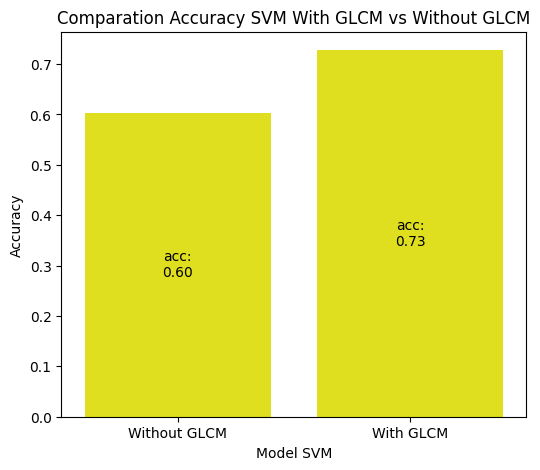

In [71]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With GLCM vs Without GLCM")

plt.show()

In [72]:
print('selisih : ', acc_wg-acc_wog)

selisih :  0.12449799196787148
